In [56]:
suppressMessages(library(tidyverse)) #loading libraries, suppresses warning messages.
suppressMessages(library(tidymodels)) 
suppressMessages(library(repr))

set.seed(4747) #setting seed for reproducibility's sake. 47 is hexadecimal for g, and our group number "g47"

## Project Proposal

In [2]:
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
dir.create("data")
download.file(url, "data/top500players.csv") # creates directory "data" and downloads the data used into the folder

### RUN THIS BLOCK ONLY ONCE 

In [10]:
player_data <- read_csv("data/top500players.csv", show_col_types = FALSE)
glimpse(player_data)

New names:
* `` -> ...1



Rows: 500
Columns: 38
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1~
$ Age                <chr> "26 (25-04-1993)", "18 (22-12-2001)", "32 (03-11-19~
$ Country            <chr> "Brazil", "United Kingdom", "Slovakia", "Korea, Rep~
$ Plays              <chr> "Right-handed", "Left-handed", "Right-handed", "Rig~
$ Wikipedia          <chr> "Wikipedia", "Wikipedia", "Wikipedia", "Wikipedia",~
$ `Current Rank`     <chr> "378 (97)", "326 (119)", "178 (280)", "236 (199)", ~
$ `Best Rank`        <chr> "363 (04-11-2019)", "316 (14-10-2019)", "44 (14-01-~
$ Name               <chr> "Oscar Jose Gutierrez", "Jack Draper", "Lukas Lacko~
$ Backhand           <chr> NA, "Two-handed", "Two-handed", "Two-handed", "Two-~
$ `Prize Money`      <chr> NA, "$59,040", "US$3,261,567", "$374,093", "US$6,09~
$ Height             <chr> NA, NA, "185 cm", NA, "193 cm", NA, NA, NA, NA, NA,~
$ `Favorite Surface` <chr> NA, NA, "Fast (H, G) 40%", NA, "Fast (H, G) 36%", "~
$ `Turned Pro`    

In [54]:
colnames(player_data) <- make.names(colnames(player_data))

player_data_tidy <- player_data |>
                        separate(Age, c("Age", NA), sep = " ") |> #Removes the DOB next to the Age
                        separate(Current.Elo.Rank, c("Current.Rank", NA), sep = " ") |> #Removes the elo next to the ranks
                        select(Age, Name, Seasons, Current.Rank) |>
                        na.omit() |>
                        mutate(Age = as.numeric(Age)) |>
                        mutate(Current.Rank = as.numeric(Current.Rank))

head(player_data_tidy)

# cuts Current.Rank into different intervals with step 20.
## "labels" arg names each interval.
Current_Rank_factor <- player_data_tidy$Current.Rank |>
                            cut(c(0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200), 
                                labels = c("1-20", "21-40", "41-60", "61-80", "81-100",
                                           "101-120", "121-140", "141-160", "161-180", "181-200")) 

player_data_factor <- mutate(player_data_tidy, Rank.Range = Current_Rank_factor) #vector is added to df
head(player_data_factor)

Age,Name,Seasons,Current.Rank
<dbl>,<chr>,<dbl>,<dbl>
32,Lukas Lacko,14,144
27,Bernard Tomic,11,100
22,Hubert Hurkacz,5,33
25,Sanjar Fayziev,5,189
19,Felix Auger Aliassime,3,51
23,Daniil Medvedev,5,5


Age,Name,Seasons,Current.Rank,Rank.Range
<dbl>,<chr>,<dbl>,<dbl>,<fct>
32,Lukas Lacko,14,144,141-160
27,Bernard Tomic,11,100,81-100
22,Hubert Hurkacz,5,33,21-40
25,Sanjar Fayziev,5,189,181-200
19,Felix Auger Aliassime,3,51,41-60
23,Daniil Medvedev,5,5,1-20


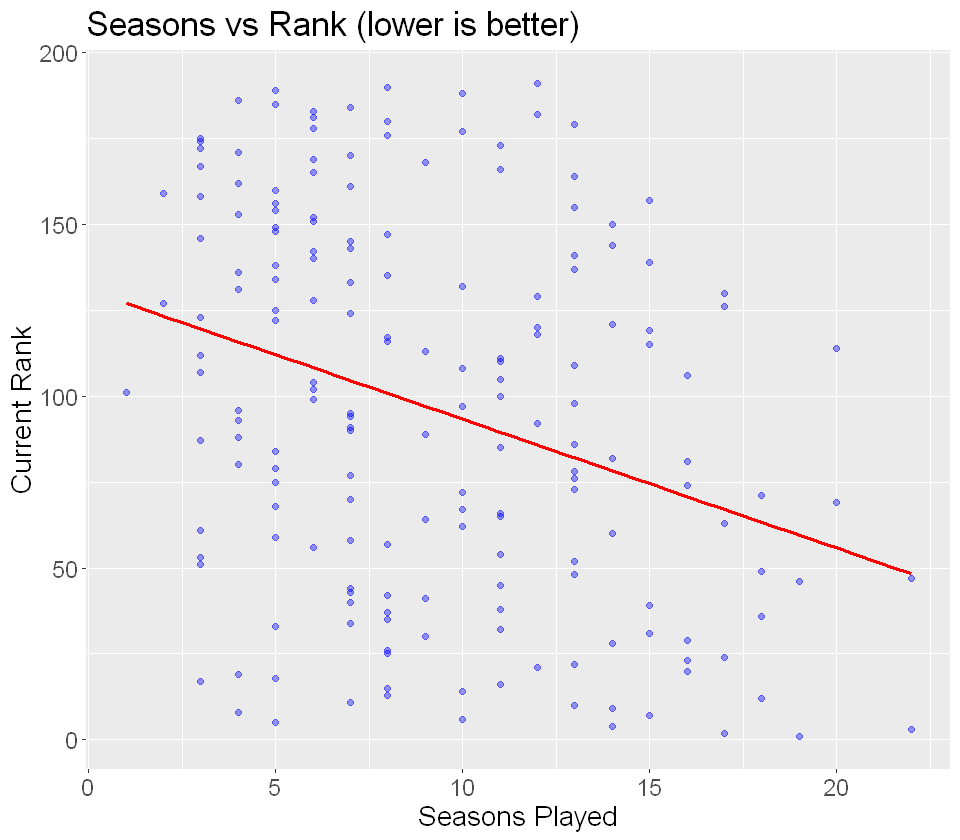

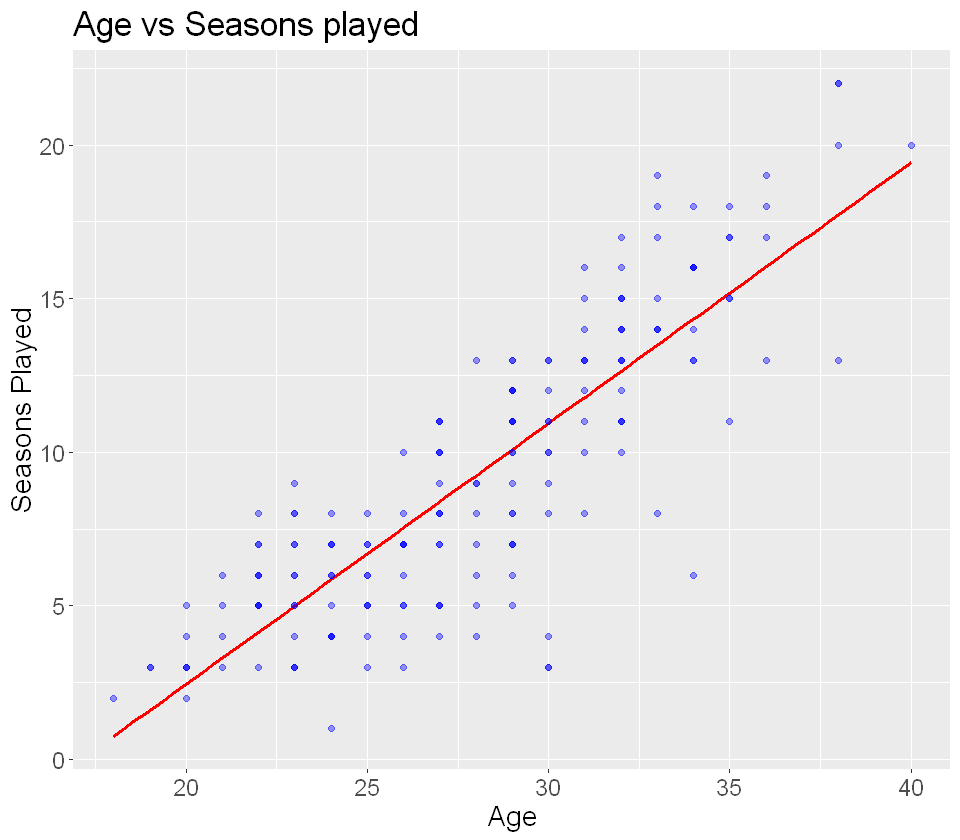

In [36]:
options(repr.plot.length = 10, repr.plot.width = 8)

SeasonsVsRank <- ggplot(player_data_tidy, aes(x = Seasons, y = Current.Rank)) + 
                    geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(colour = "blue", alpha = 0.4) +
                     labs(x = "Seasons Played", y = "Current Rank", title = "Seasons vs Rank (lower is better)") + 
                     theme(text = element_text(size = 17)) #legend could be added


AgeVsSeasons <- ggplot(player_data_tidy, aes(x = Age, y = Seasons)) + 
                    geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Age", y = "Seasons Played", title = "Age vs Seasons") + 
                     theme(text = element_text(size = 17)) #legend could be added


SeasonsVsRank
AgeVsSeasons

In [86]:
set.seed(4747)

player_split <- initial_split(player_data_factor, prop = .80, strata = Rank.Range)
player_training <- training(player_split)
player_testing <- testing(player_split)

player_vfold <- vfold_cv(player_training, v = 5, strata = Rank.Range)

player_recipe <- recipe(Rank.Range ~ Seasons, data = player_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 14, to = 30, by = 1))

player_resamples_metrics <- workflow() |>
                            add_model(knn_spec) |>
                            add_recipe(player_recipe) |>
                            tune_grid(resamples = player_vfold, grid = k_vals) |>
                            collect_metrics()

resamples_metrics_clean <- player_resamples_metrics |>
                                filter(.metric == "accuracy") |>
                                arrange(desc(mean))

resamples_metrics_clean

! Fold1: internal: No observations were detected in `truth` for level(s): '181-20...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,multiclass,0.1693722,5,0.02327197,Preprocessor1_Model06
30,accuracy,multiclass,0.1622458,5,0.02609884,Preprocessor1_Model17
25,accuracy,multiclass,0.1553492,5,0.02135036,Preprocessor1_Model12
28,accuracy,multiclass,0.1553492,5,0.02397382,Preprocessor1_Model15
29,accuracy,multiclass,0.1553492,5,0.02397382,Preprocessor1_Model16
22,accuracy,multiclass,0.1545535,5,0.01545825,Preprocessor1_Model09
27,accuracy,multiclass,0.1484527,5,0.02373738,Preprocessor1_Model14
18,accuracy,multiclass,0.1473210,5,0.02047629,Preprocessor1_Model05
17,accuracy,multiclass,0.1470911,5,0.01308067,Preprocessor1_Model04
